In [1]:
import sys
sys.path.append('/home/rwb/github/skaworkflows')

import logging
import json

from pathlib import Path


logging.basicConfig(level='INFO')
LOGGER = logging.getLogger(__name__)
%pwd 


'/home/rwb/github/thesis_experiments/chapter3'

In [2]:
workflow_data_path = Path('low/prototype/workflows/data_overview/hpso01_time-18000_channels-896_tel-512_no_data.json_DPrepA_data')
system_config_path = Path('workflow_data_allocation/no_data_low_sdp_config_prototype_n896_896channels.json')

with open(workflow_data_path) as fp: 
    workflow_data = json.load(fp)
    
with open(system_config_path) as fp: 
    system_config = json.load(fp)
    

workflow_data, system_config

({'End': {'node': 1},
  'lstnr': {'node': 1},
  'UpdateGSM': {'node': 1792, 'out_edge': 1792},
  'UpdateLSM': {'node': 1792,
   'out_edge': 1792,
   'total_compute': 0.0004935489391828,
   'fraction_compute_cost': 2.7541793481183035e-07,
   'total_data': 673.0212807039582,
   'fraction_data_cost': 0.3755699111071195},
  'CalSourceFinding': {'node': 1792, 'out_edge': 1792},
  'Average': {'node': 1792,
   'out_edge': 1792,
   'total_compute': 0.0,
   'fraction_compute_cost': 0.0,
   'total_data': 0.0,
   'fraction_data_cost': 0.0},
  'Predict': {'node': 3584,
   'out_edge': 1792,
   'total_compute': 2.068153023186825,
   'fraction_compute_cost': 0.0005770516247731096,
   'total_data': 1419.1955765138346,
   'fraction_data_cost': 0.3959809086255119},
  'Solve': {'node': 1792,
   'out_edge': 3584,
   'total_compute': 0.0,
   'fraction_compute_cost': 0.0,
   'total_data': 0.0,
   'fraction_data_cost': 0.0},
  'Correct': {'node': 1792,
   'out_edge': 1792,
   'total_compute': 0.0599460462918

In [3]:
# Setup multipler for a given observation
obs_time = 18000
compute_unit = 10**15 # Peta flop
data_unit = 10**6 # per million visibilites 
bytes_per_vis = 12 

In [4]:
# Isolate a single unit of computing 

import pandas as pd

flops,compute_bandwidth,memory = system_config['cluster']['system']['resources']['GenericSDP_m0'].values()
print(flops/10**12, compute_bandwidth/10**9)

df_list = []

for product in workflow_data:
    curr_product_dict = workflow_data[product]
    if 'total_compute' in workflow_data[product]: 
        d = {
            'product':product,
            'compute': curr_product_dict['fraction_compute_cost']  * obs_time * compute_unit,
            'total_compute': curr_product_dict['total_compute'] * obs_time * compute_unit,
            'data': curr_product_dict['fraction_data_cost'] * obs_time * data_unit * bytes_per_vis,
            'total_data': curr_product_dict['total_data'] * obs_time  * data_unit * bytes_per_vis # /(10**9)
        } 
        df_list.append(d)

df = pd.DataFrame(df_list)
df['compute_time'] = df['compute']/flops
df['data_time'] = df['data']/compute_bandwidth
df[['product', 'compute_time', 'data_time']]

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


10.726 7.5304827


,product,compute_time,data_time
0,UpdateLSM,0.462197,10.772630
1,Average,0.000000,0.000000
2,Predict,968.387959,11.358087
3,Solve,0.000000,0.000000
4,Correct,56.138041,22.715880
5,Subtract,0.016708,3.245126
6,Flag,5.438373,7.571960
7,IFFT,11.953025,0.000147
8,Degrid,42.703280,122.005685
9,FFT,11.953025,0.000147


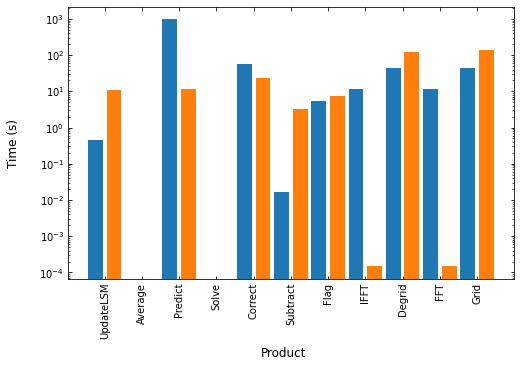

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))


fig.supxlabel('Product', y=-0.1), fig.supylabel('Time (s)')

# Look into representing this as something like a distribution across all workflows
# Seaborn categorical scatterplots could be a good start: https://seaborn.pydata.org/tutorial/categorical.html#categorical-scatterplots

x_label = df['product']
x_compute = df['compute']/(flops)
x_data = df['data']/(compute_bandwidth)
x = np.arange(0, 2*len(x_label), step=2)

ax.bar(x - 0.5, x_compute,log=True,zorder=1)
ax.bar(x + 0.5, x_data)
ax.set_xticks(x, x_label,rotation='vertical')
ax.tick_params(right=True, top=True, which='both', direction='in')
plt.savefig('output.png')

,product,compute,total_compute,data,total_data,compute_time,data_time
0,UpdateLSM,4.957523e+12,8.883881e+15,8.112310e+10,1.453726e+14,0.462197,10.772630
1,Average,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
2,Predict,1.038693e+16,3.722675e+19,8.553188e+10,3.065462e+14,968.387959,11.358087
3,Solve,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
4,Correct,6.021366e+14,1.079029e+18,1.710615e+11,3.065423e+14,56.138041,22.715880
5,Subtract,1.792073e+11,2.247977e+15,2.443736e+10,3.065423e+14,0.016708,3.245126
6,Flag,5.833199e+13,3.135928e+17,5.702051e+10,3.065423e+14,5.438373,7.571960
7,IFFT,1.282081e+14,4.594980e+17,1.105567e+06,3.962353e+09,11.953025,0.000147
8,Degrid,4.580354e+14,1.641599e+18,9.187617e+11,3.292842e+15,42.703280,122.005685
9,FFT,1.282081e+14,4.594980e+17,1.105567e+06,3.962353e+09,11.953025,0.000147


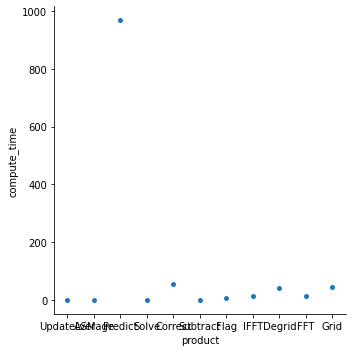

In [12]:
# For categorical plot, we want to reshape the data so the time is either compute or data
# i.e. rather than Product| workflow | Data time | compute time | , we have | product | workflow | time | type 

sns.catplot(data=df,x='product', y='compute_time')
df

In [133]:
Rvis = 592420
(Rvis *10**6 * 18000 * 12)/3500/compute_bandwidth/60

1.038693e+16/flops/60

16.13980048480328